## Installing Modules

In [1]:
!pip install pytorch_lightning torchmetrics tableprint spacy==3
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

     |████████████████████████████████| 819kB 6.2MB/s 
     |████████████████████████████████| 235kB 20.1MB/s 
     |████████████████████████████████| 12.7MB 237kB/s 
     |████████████████████████████████| 645kB 37.4MB/s 
     |████████████████████████████████| 122kB 43.3MB/s 
     |████████████████████████████████| 829kB 43.1MB/s 
     |████████████████████████████████| 10.6MB 12.9MB/s 
     |████████████████████████████████| 9.1MB 31.8MB/s 
     |████████████████████████████████| 624kB 43.2MB/s 
     |████████████████████████████████| 460kB 44.7MB/s 
     |████████████████████████████████| 51kB 8.3MB/s 
     |████████████████████████████████| 1.3MB 42.5MB/s 
     |████████████████████████████████| 143kB 57.8MB/s 
     |████████████████████████████████| 296kB 52.8MB/s 
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491070 sha256=070c1efeddd857355b42ee40563230df2fc629dd087e5f9b012f711454fc795a
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dc

## Imports

In [2]:
# Import Libraries
import random
from typing import Iterable, List, Tuple
import pandas as pd
import sys, os, pickle
import numpy as np
import math
import matplotlib.pyplot  as plt
import spacy

# PyTorch related
import torch, torchtext
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import Multi30k
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

# My Custom Code
import pytorch_lightning as pl
import torchmetrics
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint
import tableprint as tp



/usr/local/lib/python3.7/dist-packages/pytorch_lightning/metrics/__init__.py:44: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  "`pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package"


In [3]:
# Manual Seed
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Language Definitions

In [5]:
SRC_LANGUAGE = 'de'
TGT_LANGUAGE = 'en'

# Place-holders
token_transform = {}
vocab_transform = {}

## Tokenizers

In [6]:
token_transform[SRC_LANGUAGE]  = get_tokenizer('spacy', language='de_core_news_sm')
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')

## Yield Function

This yields the tokens for the texts and will be used to build the vocab

In [7]:
def yield_tokens(data_iter: Iterable, language: str) -> List[str]:
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

    for data_sample in data_iter:
        yield token_transform[language](data_sample[language_index[language]])

## Special Tokens

In [8]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

Build the vocab here

In [9]:
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
  # Training data Iterator 
  train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
  # Create torchtext's Vocab object 
  vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_iter, ln),
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)

training.tar.gz: 100%|██████████| 1.21M/1.21M [00:01<00:00, 1.08MB/s]


### Setting the default index as the <unk> token

In [10]:
# Set UNK_IDX as the default index. This index is returned when the token is not found. 
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary. 
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
  vocab_transform[ln].set_default_index(UNK_IDX)

In [11]:
len(vocab_transform['de'])

19215

In [12]:
len(vocab_transform['en'])

10838

## Collator

In [13]:
# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]), 
                      torch.tensor(token_ids), 
                      torch.tensor([EOS_IDX])))

# src and tgt language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

## DataLoader

In [14]:
BATCH_SIZE = 32
train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
train_loader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=1)

val_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
val_loader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=1)

test_iter = Multi30k(split='test', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
test_loader = DataLoader(test_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=1)

validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 168kB/s]
mmt16_task1_test.tar.gz: 100%|██████████| 43.9k/43.9k [00:00<00:00, 158kB/s]


## Model

### Boilerplate Code for PyTorch Lightning

In [15]:
class TL(pl.LightningModule):
    def __init__(self):
        super(TL, self).__init__()

        self.train_acc =  torch.tensor(0.)
        self.avg_train_loss = torch.tensor(0.)
        self.table_context = None
        

    def training_step(self, batch, batch_idx):
        src, trg = batch 
        output = self(src, trg)
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        loss_train = self.loss(output, trg)
        return loss_train
    
    def validation_step(self, batch, batch_idx):
        src, trg = batch  
        output = self(src, trg, 0)
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        loss_valid = self.loss(output, trg) 
        return {"loss": loss_valid}
    
    def training_epoch_end(self, outputs):
        self.avg_train_loss = torch.stack([x['loss'] for x in outputs]).mean()
    
    def validation_epoch_end(self, outputs):
        if trainer.sanity_checking:
          print('sanity check')
          return
        avg_valid_loss = torch.stack([x['loss'] for x in outputs]).mean()
        metrics = {'epoch': self.current_epoch+1, 'Train PPL': math.exp(self.avg_train_loss), 'Train Loss': self.avg_train_loss,  'Valid PPL': math.exp(avg_valid_loss), 'Valid Loss': avg_valid_loss}
        if self.table_context is None:
          self.table_context = tp.TableContext(headers=['epoch', 'Train PPL', 'Train Loss', 'Valid PPL', 'Valid Loss'])
          self.table_context.__enter__()
        self.table_context([self.current_epoch+1, math.exp(self.avg_train_loss.item()), self.avg_train_loss.item(), math.exp(avg_valid_loss.item()), avg_valid_loss.item()])
        self.logger.log_metrics(metrics)
        if self.current_epoch == self.trainer.max_epochs - 1:
          self.validation_end(outputs)
    
    def validation_end(self, outputs):
        self.table_context.__exit__()

### Encoder

In [16]:
class Encoder(pl.LightningModule):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        
        self.hid_dim = enc_hid_dim
        
        self.embedding = nn.Embedding(input_dim, emb_dim)  
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        output, hidden = self.rnn(embedded)
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        return output, hidden

## Attention

In [17]:
class Attention(pl.LightningModule):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
        
    def forward(self, hidden, encoder_outputs):
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)      
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 

        attention = self.v(energy).squeeze(2)        
        return F.softmax(attention, dim=1)


### Decoder

In [18]:
class Decoder(pl.LightningModule):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.hid_dim = dec_hid_dim
        self.output_dim = output_dim
        self.attention = attention



        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs):
        input = input.unsqueeze(0)        
        embedded = self.dropout(self.embedding(input))
               
        a = self.attention(hidden, encoder_outputs)
                       
        a = a.unsqueeze(1)
                
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
                
        weighted = torch.bmm(a, encoder_outputs)
                
        weighted = weighted.permute(1, 0, 2)
                
        rnn_input = torch.cat((embedded, weighted), dim = 2)
                    
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))

        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
                
        return prediction, hidden.squeeze(0)

### Seq2Seq Model

In [19]:
# Define the model

class Seq2Seq(TL):
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq, self).__init__()
        
        self.loss = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
        self.lr = 1e-3
        
        self.encoder = encoder
        self.decoder = decoder
        # self.device = device # Doesn't work in PyTorchLightning since it is already defined!

            
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)

        encoder_outputs, hidden = self.encoder(src)
                        
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            output, hidden = self.decoder(input, hidden, encoder_outputs)
            
            outputs[t] = output
            
            teacher_force = random.random() < teacher_forcing_ratio
            
            top1 = output.argmax(1) 
            
            input = trg[t] if teacher_force else top1

        return outputs
    
    def configure_optimizers(self):
        optim = torch.optim.Adam(self.parameters())
        return optim

## Model Initialization and Summary

In [20]:
INPUT_DIM = len(vocab_transform[SRC_LANGUAGE])
OUTPUT_DIM = len(vocab_transform[TGT_LANGUAGE])

ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5


attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, device).to(device)

### Model Checkpoint

In [21]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='/content',
    filename='sst-{epoch:02d}-{val_loss:.2f}',
    mode='min'
)

In [22]:
!rm -rf csv_logs
csvlogger = CSVLogger('csv_logs', name='END2_Assign_8', version=0)
trainer = pl.Trainer(max_epochs=10, num_sanity_val_steps=1, logger=csvlogger, gpus=1, callbacks=[checkpoint_callback], gradient_clip_val=1, gradient_clip_algorithm='norm')
trainer.fit(model, train_dataloader=train_loader, val_dataloaders=val_loader)
checkpoint_callback.best_model_path

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params
---------------------------------------------
0 | loss    | CrossEntropyLoss | 0     
1 | encoder | Encoder          | 7.8 M 
2 | decoder | Decoder          | 25.8 M
---------------------------------------------
33.6 M    Trainable params
0         Non-trainable params
33.6 M    Total params
134.238   Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/data.py:42: UserWarning: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.
  'Your `IterableDataset` has `__len__` defined.'


sanity check


╭─────────────┬─────────────┬─────────────┬─────────────┬─────────────╮
│       epoch │   Train PPL │  Train Loss │   Valid PPL │  Valid Loss │
├─────────────┼─────────────┼─────────────┼─────────────┼─────────────┤
│           1 │      48.576 │      3.8831 │      41.079 │      3.7155 │


│           2 │      18.493 │      2.9174 │      41.181 │       3.718 │


│           3 │      12.191 │      2.5007 │      42.365 │      3.7463 │


│           4 │      9.4235 │      2.2432 │      45.319 │      3.8137 │


│           5 │      8.2057 │      2.1048 │      52.213 │      3.9553 │


│           6 │      7.4154 │      2.0036 │      57.498 │      4.0517 │


│           7 │      6.8446 │      1.9235 │      56.115 │      4.0274 │


│           8 │      6.4283 │      1.8607 │      60.296 │      4.0993 │


│           9 │      6.0567 │      1.8012 │      63.326 │      4.1483 │


│          10 │         5.9 │       1.775 │      65.951 │      4.1889 │
╰─────────────┴─────────────┴─────────────┴─────────────┴─────────────╯



''

## Training Log

In [23]:
root='./csv_logs/' + 'END2_Assign_8' + '/'
dirlist = [ item for item in os.listdir(root) if os.path.isdir(os.path.join(root, item)) ]
metricfile = root + dirlist[-1:][0] + '/metrics.csv'
metrics = pd.read_csv(metricfile)

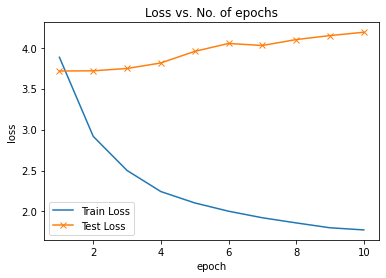

In [24]:
plt.plot(metrics['epoch'], metrics['Train Loss'], label="Train Loss")
plt.plot(metrics['epoch'], metrics['Valid Loss'], '-x', label="Test Loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.title('Loss vs. No. of epochs');

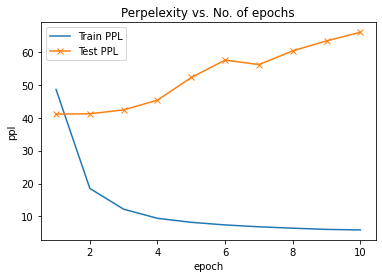

In [25]:
plt.plot(metrics['epoch'], metrics['Train PPL'], label="Train PPL")
plt.plot(metrics['epoch'], metrics['Valid PPL'], '-x', label="Test PPL")
plt.xlabel('epoch')
plt.ylabel('ppl')
plt.legend()
plt.title('Perpelexity vs. No. of epochs');

## Inference on Random Samples from Test Data

In [26]:
model.to(device)
model.eval()

Seq2Seq(
  (loss): CrossEntropyLoss()
  (encoder): Encoder(
    (embedding): Embedding(19215, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(10838, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=10838, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [27]:
for i in np.random.randint(0,32, 10):
  src_sent_i = next(iter(test_loader))[0][:,i]
  trg_sent_i = next(iter(test_loader))[1][:,i]
  stop_ind_src = (src_sent_i==3).nonzero()[0].item() # stop when <eos> token is found
  stop_ind_trg = (trg_sent_i==3).nonzero()[0].item() # stop when <eos> token is found
  src_sent_tok = [vocab_transform['de'].lookup_token(word_i) for word_i in src_sent_i[:stop_ind_src]]
  trg_sent_tok = [vocab_transform['en'].lookup_token(word_i) for word_i in trg_sent_i[:stop_ind_trg]]
  src_sent = " ".join(src_sent_tok[1:]) # skip the initial <bos> token
  trg_sent = " ".join(trg_sent_tok[1:]) # skip the initial <bos> token
  src_sent_tensor = src_sent_i.clone().detach().unsqueeze(1).to(device)   
  trg_sent_tensor = trg_sent_i.clone().detach().unsqueeze(1).to(device)   
  with torch.no_grad():
        output = model(src_sent_tensor, trg_sent_tensor, 1)
        out = output.squeeze(1)
        out = torch.argmax(out,dim=1)
        stop_ind_pred = (out==3).nonzero()[0].item() # stop when <eos> token is found
        trans = []
        pred_sent_tok = [vocab_transform['en'].lookup_token(word_i) for word_i in out]
        pred_sent = " ".join(pred_sent_tok[1:stop_ind_pred])
        start = "\033[1m"
        end = "\033[0;0m"
        print(f'{start}Source Sentence: {end}{src_sent}')
        print(f'{start}Target Sentence: {end}{trg_sent}')
        print(f'{start}Translated Sentence: {end}{pred_sent}')
        print()

Source Sentence: Ein Mädchen in einem Jeanskleid läuft über einen erhöhten Schwebebalken .
Target Sentence: A girl in a jean dress is walking along a raised balance beam .
Translated Sentence: A girl in a red is is a a a raised balance . .

Source Sentence: Zwei Männer tun so als seien sie Statuen , während Frauen ihnen zusehen .
Target Sentence: Two men pretend to be <unk> while women look on .
Translated Sentence: Two men are as be as as as watch on .

Source Sentence: Eine Gruppe von Menschen steht vor einem Iglu .
Target Sentence: A group of people standing in front of an igloo .
Translated Sentence: A group of people standing in a of a igloo .

Source Sentence: Eine Teenagerin spielt bei einem Spiel Trompete auf dem Feld .
Target Sentence: A teenager plays her trumpet on the field at a game .
Translated Sentence: A teenage plays in in in a game in a game .

Source Sentence: Eine Frau , die in einer Küche eine Schale mit Essen hält .
Target Sentence: A woman holding a bowl of food 